In [ ]:
#SETUP CELL
print("Installing system dependencies...")
!apt-get update -qq && apt-get install -y build-essential swig -qq > /dev/null

print("Installing Python packages...")
!pip install -q optuna gymnasium[box2d] mujoco gymnasium-robotics > /dev/null
print("Installation complete.")

In [2]:
#Imports
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Categorical, Normal
from torch.nn.utils.convert_parameters import parameters_to_vector, vector_to_parameters
import time
import random
import matplotlib.pyplot as plt

# Global configuration
SEED = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")
print(f"Global seed: {SEED}")


Installing system dependencies...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Installing Python packages...
Installation complete.

Using device: cuda
Global seed: 6




Running FINAL training for: CartPole-v1
--- Training for 50 epochs ---
Epoch: 1/50 | Avg Reward: 21.08 | Time: 5.67s
Epoch: 2/50 | Avg Reward: 24.28 | Time: 9.85s
Epoch: 3/50 | Avg Reward: 25.94 | Time: 14.76s
Epoch: 4/50 | Avg Reward: 34.88 | Time: 19.12s
Epoch: 5/50 | Avg Reward: 39.40 | Time: 23.29s
Epoch: 6/50 | Avg Reward: 41.17 | Time: 27.98s
Epoch: 7/50 | Avg Reward: 46.29 | Time: 32.15s
Epoch: 8/50 | Avg Reward: 47.43 | Time: 36.41s
Epoch: 9/50 | Avg Reward: 54.78 | Time: 40.99s
Epoch: 10/50 | Avg Reward: 51.89 | Time: 45.20s
Epoch: 11/50 | Avg Reward: 53.58 | Time: 49.77s
Epoch: 12/50 | Avg Reward: 56.23 | Time: 54.26s
Epoch: 13/50 | Avg Reward: 60.38 | Time: 58.42s
Epoch: 14/50 | Avg Reward: 63.47 | Time: 63.09s
Epoch: 15/50 | Avg Reward: 60.22 | Time: 67.90s
Epoch: 16/50 | Avg Reward: 64.14 | Time: 72.02s
Epoch: 17/50 | Avg Reward: 68.25 | Time: 76.78s
Epoch: 18/50 | Avg Reward: 72.17 | Time: 80.93s
Epoch: 19/50 | Avg Reward: 73.27 | Time: 85.29s
Epoch: 20/50 | Avg Reward:

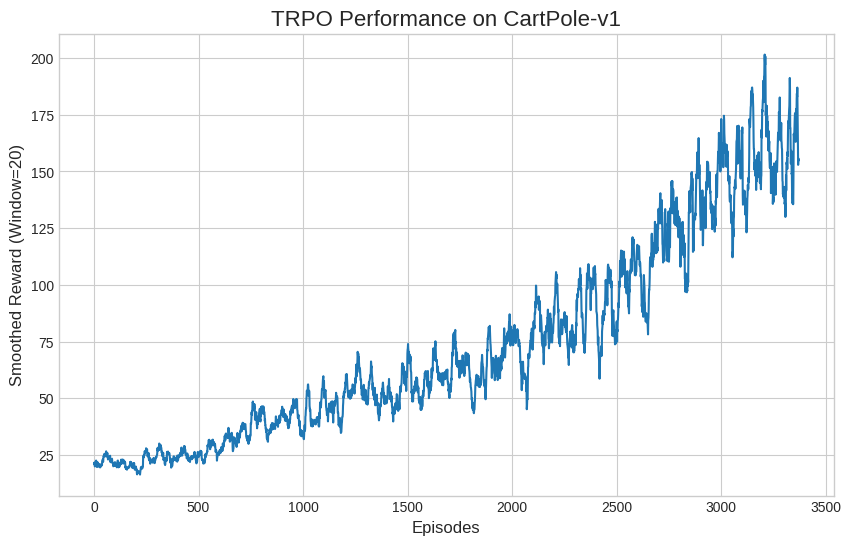

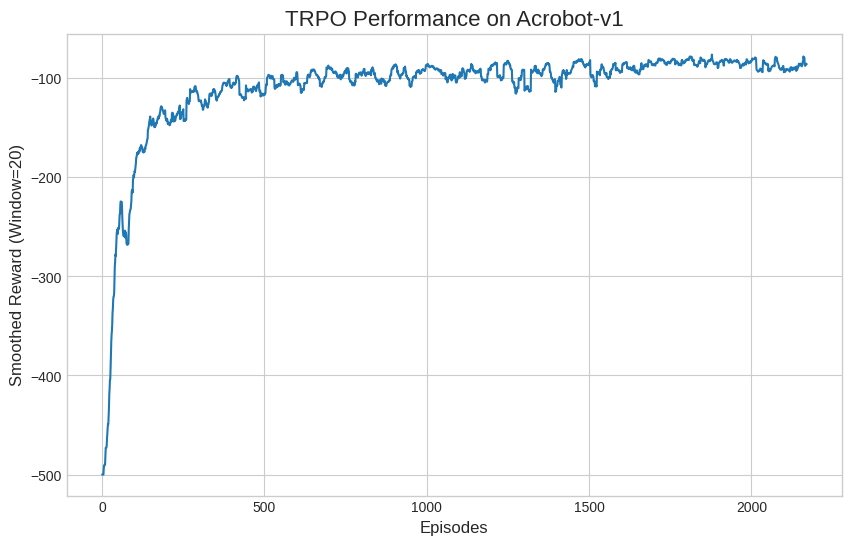

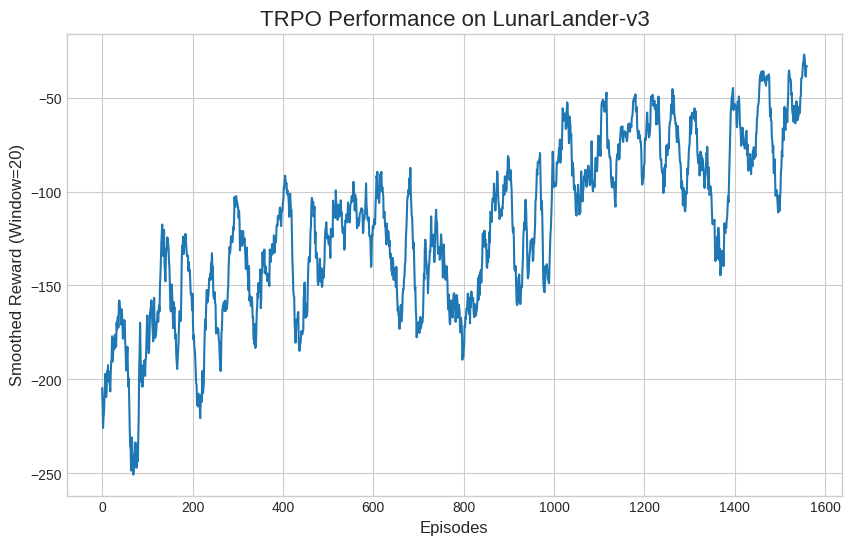

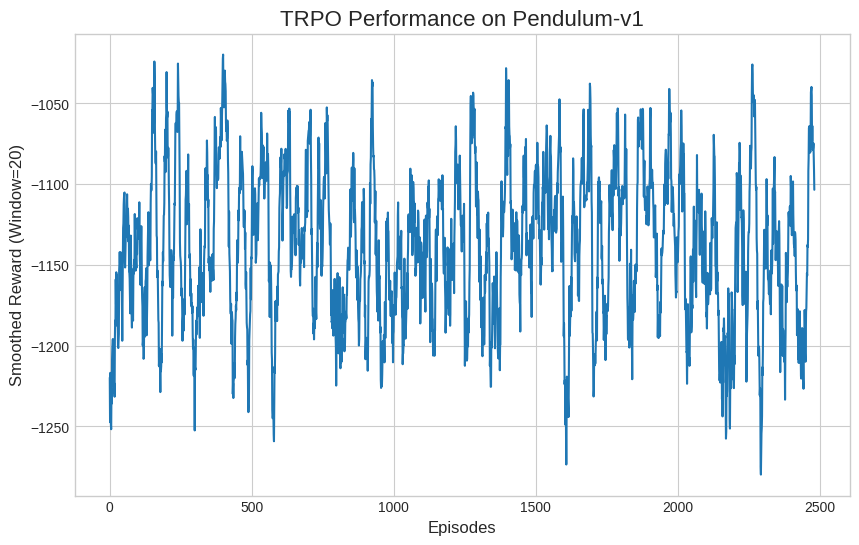

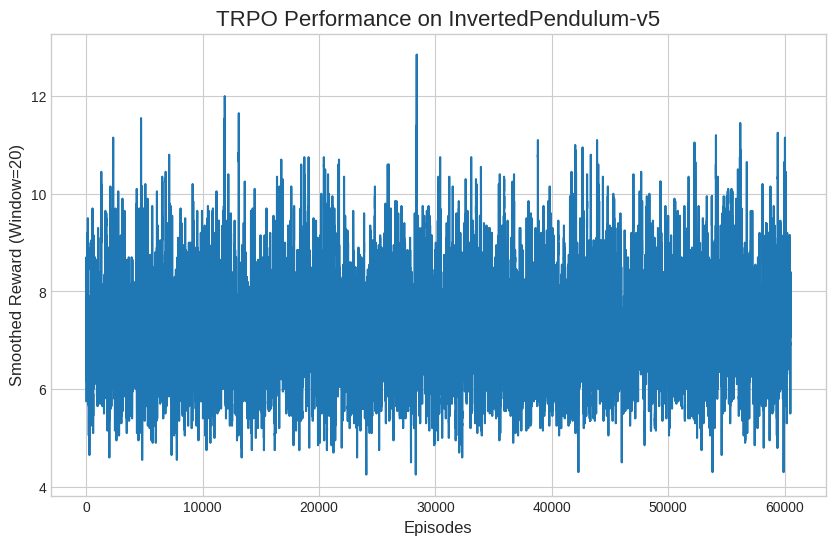

In [3]:
# Defines the Actor-Critic neural network architecture.
# It uses shared layers for feature extraction and separate heads for the policy (actor) and value function (critic).
# The network can handle both continuous and discrete action spaces.
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, is_continuous):
        super(ActorCritic, self).__init__()
        self.is_continuous = is_continuous
        self.shared_layers = nn.Sequential(
            nn.Linear(state_dim, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh()
        )
        self.actor_head = nn.Linear(64, action_dim)
        self.critic_head = nn.Linear(64, 1)
        if is_continuous:
            self.log_std = nn.Parameter(torch.zeros(1, action_dim))

    def forward(self, state):
        shared_features = self.shared_layers(state)
        value = self.critic_head(shared_features)
        if self.is_continuous:
            mean = self.actor_head(shared_features)
            std = torch.exp(self.log_std)
            dist = Normal(mean, std)
        else:
            logits = self.actor_head(shared_features)
            dist = Categorical(logits=logits)
        return dist, value

# Calculates the Generalized Advantage Estimation (GAE) and returns for a batch of trajectories.
# GAE provides a fine-tuned balance between high-variance Monte Carlo estimates and high-bias TD estimates.
def compute_gae(rewards, values, dones, gamma, lambda_gae):
    advantages = []
    last_advantage = 0
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t+1] * (1 - dones[t]) - values[t]
        last_advantage = delta + gamma * lambda_gae * (1 - dones[t]) * last_advantage
        advantages.insert(0, last_advantage)

    advantages = torch.tensor(advantages, dtype=torch.float32).to(device)
    returns = advantages + torch.tensor(values[:-1], dtype=torch.float32).to(device)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    return advantages, returns

# Computes the average Kullback-Leibler (KL) divergence between two policies given a set of states.
# This is used as the trust region constraint in TRPO, ensuring policy updates are not too large.
def get_kl(old_policy, new_policy, states):
    """Computes the average KL divergence between two policies."""
    old_dist, _ = old_policy(states)
    new_dist, _ = new_policy(states)

    if isinstance(old_dist, Normal):
        # KL for Normal distributions
        old_mean, old_std = old_dist.mean, old_dist.stddev
        new_mean, new_std = new_dist.mean, new_dist.stddev
        kl = torch.log(new_std / old_std) + (old_std.pow(2) + (old_mean - new_mean).pow(2)) / (2 * new_std.pow(2)) - 0.5
        return kl.sum(1, keepdim=True).mean()
    else:
        # KL for Categorical distributions
        old_p = old_dist.probs
        new_p = new_dist.probs
        kl = (old_p * (torch.log(old_p) - torch.log(new_p))).sum(dim=1).mean()
        return kl

# Computes the product of the Fisher Information Matrix (F) and a vector (p) without forming the full F matrix.
# This is a key optimization for TRPO, making the computation of the search direction feasible.
def fisher_vector_product(policy, states, p):
    """Computes the Fisher-vector product F*p without forming the full F matrix."""
    policy.zero_grad()
    kl_div = get_kl(policy, policy, states)

    # Get the gradient of KL divergence w.r.t. policy parameters
    kl_grads = torch.autograd.grad(kl_div, policy.actor_head.parameters(), create_graph=True)
    kl_grads_flat = torch.cat([grad.view(-1) for grad in kl_grads])

    # Compute the dot product (kl_grads_flat * p)
    grad_vector_product = (kl_grads_flat * p).sum()

    # Compute the gradient of the dot product w.r.t. policy parameters
    # This is the second derivative (Hessian-vector product), which is F*p
    fvp = torch.autograd.grad(grad_vector_product, policy.actor_head.parameters())
    fvp_flat = torch.cat([grad.contiguous().view(-1) for grad in fvp])

    # Damping for stability
    return fvp_flat + 0.1 * p

# Solves the linear system Fx = g for x using the Conjugate Gradient algorithm.
# Here, F is the Fisher Information Matrix and g is the policy gradient. The solution x is the optimal search direction.
def conjugate_gradient(policy, states, b, n_steps=10):
    """Solves the linear system Ax=b for x using Conjugate Gradient."""
    x = torch.zeros_like(b)
    r = b.clone()
    p = b.clone()
    rs_old = r.dot(r)

    for _ in range(n_steps):
        Ap = fisher_vector_product(policy, states, p)
        alpha = rs_old / (p.dot(Ap) + 1e-8)
        x += alpha * p
        r -= alpha * Ap
        rs_new = r.dot(r)
        if torch.sqrt(rs_new) < 1e-10:
            break
        p = r + (rs_new / rs_old) * p
        rs_old = rs_new

    return x

# Main training loop for the TRPO algorithm.
# It orchestrates data collection, advantage estimation, policy updates via conjugate gradient and line search, and critic updates.
def train(config):
    seed = config["seed"]
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)

    env = gym.make(config["env_name"])
    env.reset(seed=seed); env.action_space.seed(seed)
    state_dim = env.observation_space.shape[0]
    is_continuous = isinstance(env.action_space, gym.spaces.Box)
    action_dim = env.action_space.shape[0] if is_continuous else env.action_space.n

    policy = ActorCritic(state_dim, action_dim, is_continuous).to(device)
    value_optimizer = torch.optim.Adam(policy.critic_head.parameters(), lr=config["lr_critic"])

    start_time = time.time()
    all_episode_rewards = []
    print(f"--- Training for {config['epochs']} epochs ---")

    for epoch in range(config["epochs"]):
        # Data Collection
        batch_states, batch_actions, batch_rewards, batch_values, batch_dones = [], [], [], [], []
        ep_rewards_in_epoch = []
        steps_in_epoch = 0; state, _ = env.reset(); current_episode_reward = 0
        while steps_in_epoch < config["steps_per_epoch"]:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                dist, value = policy(state_tensor)
                action = dist.sample()
            action_np = action.cpu().numpy()[0]
            next_state, reward, terminated, truncated, _ = env.step(action_np)
            done = terminated or truncated
            batch_states.append(state_tensor); batch_actions.append(action); batch_rewards.append(reward)
            batch_values.append(value.cpu().item()); batch_dones.append(done)
            state = next_state; steps_in_epoch += 1; current_episode_reward += reward
            if done:
                all_episode_rewards.append(current_episode_reward)
                ep_rewards_in_epoch.append(current_episode_reward)
                state, _ = env.reset(); current_episode_reward = 0

        # GAE Calculation
        with torch.no_grad():
            _, last_value = policy(torch.FloatTensor(state).unsqueeze(0).to(device))
            batch_values.append(last_value.cpu().item())
        advantages, returns = compute_gae(batch_rewards, batch_values, batch_dones, config["gamma"], config["lambda_gae"])
        states_tensor = torch.cat(batch_states); actions_tensor = torch.cat(batch_actions)
        old_dist, _ = policy(states_tensor)
        old_log_probs = old_dist.log_prob(actions_tensor)

        # 1. Compute policy gradient (g)
        ratio = torch.exp(old_log_probs - old_log_probs.detach())
        surrogate_adv = (ratio * advantages).mean() # This is the performance of the OLD policy
        grads = torch.autograd.grad(surrogate_adv, policy.actor_head.parameters())
        g = torch.cat([grad.view(-1) for grad in grads]).detach()

        # 2. Solve for search direction (s = F^-1 * g) using CG
        s = conjugate_gradient(policy, states_tensor, g)

        # 3. Compute proposed step and perform line search
        s_dot_Hs = (fisher_vector_product(policy, states_tensor, s) * s).sum(0)
        step_dir = torch.sqrt(2 * config["delta"] / (s_dot_Hs + 1e-8)) * s

        old_params = parameters_to_vector(policy.actor_head.parameters())
        for alpha in (0.5**np.arange(10)):
            new_params = old_params + alpha * step_dir
            vector_to_parameters(new_params, policy.actor_head.parameters())

            with torch.no_grad():
                new_dist, _ = policy(states_tensor)
                new_log_probs = new_dist.log_prob(actions_tensor)
                kl_div_new_old = torch.distributions.kl.kl_divergence(old_dist, new_dist).mean()

                new_ratio = torch.exp(new_log_probs - old_log_probs.detach())
                new_surrogate_adv = (new_ratio * advantages).mean()

            if new_surrogate_adv > surrogate_adv and kl_div_new_old <= config["delta"]:
                break
        else: # If no valid step found after all alphas, revert to the old parameters
            vector_to_parameters(old_params, policy.actor_head.parameters())

        # --- Critic Update ---
        for _ in range(config["critic_iters"]):
            _, values = policy(states_tensor)
            value_loss = nn.MSELoss()(values.squeeze(), returns)
            value_optimizer.zero_grad()
            value_loss.backward()
            value_optimizer.step()

        avg_reward = np.mean(ep_rewards_in_epoch) if ep_rewards_in_epoch else 0.0
        print(f"Epoch: {epoch+1}/{config['epochs']} | Avg Reward: {avg_reward:.2f} | Time: {time.time() - start_time:.2f}s")

    env.close()
    return all_episode_rewards

#Note: The hyperparaters were not tuned beacuse TRPO takes a lot of time to run

FINAL_TRPO_CONFIGS = {
    "CartPole-v1": {
        "env_name": "CartPole-v1", "seed": 6, "epochs": 50, "steps_per_epoch": 5000,
        "gamma": 0.99, "lambda_gae": 0.97, "lr_critic": 1e-3, "critic_iters": 5, "delta": 0.01,
    },
    "Acrobot-v1": {
        "env_name": "Acrobot-v1", "seed": 6, "epochs": 50, "steps_per_epoch": 5000,
        "gamma": 0.99, "lambda_gae": 0.97, "lr_critic": 1e-3, "critic_iters": 5, "delta": 0.01,
    },
    "LunarLander-v3": {
        "env_name": "LunarLander-v3", "seed": 6, "epochs": 50, "steps_per_epoch": 5000,
        "gamma": 0.99, "lambda_gae": 0.97, "lr_critic": 1e-3, "critic_iters": 10, "delta": 0.01,
    },
    "Pendulum-v1": {
        "env_name": "Pendulum-v1", "seed": 6, "epochs": 100, "steps_per_epoch": 5000,
        "gamma": 0.99, "lambda_gae": 0.97, "lr_critic": 1e-3, "critic_iters": 10, "delta": 0.01,
    },
    "InvertedPendulum-v5": {
        "env_name": "InvertedPendulum-v5", "seed": 6, "epochs": 100, "steps_per_epoch": 5000,
        "gamma": 0.99, "lambda_gae": 0.97, "lr_critic": 1e-3, "critic_iters": 10, "delta": 0.01,
    }
}


environments_to_run = [
    "CartPole-v1",
    "Acrobot-v1",
    "LunarLander-v3",
    "Pendulum-v1",
    "InvertedPendulum-v5"
]

all_results = {}

for env_name in environments_to_run:
    print(f"\n\n{'='*20}\nRunning FINAL training for: {env_name}\n{'='*20}")
    rewards = train(FINAL_TRPO_CONFIGS[env_name])
    all_results[env_name] = rewards

# Plotting function
def moving_average(data, window_size):
    if len(data) < window_size: return np.array([])
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

print("\n\n--- Plotting Final Results ---")
for env_name, rewards in all_results.items():
    plt.figure(figsize=(10, 6))
    plt.style.use('seaborn-v0_8-whitegrid')
    smoothed_rewards = moving_average(rewards, 20)
    if smoothed_rewards.any():
        plt.plot(smoothed_rewards)
    plt.title(f"TRPO Performance on {env_name}", fontsize=16)
    plt.xlabel("Episodes", fontsize=12)
    plt.ylabel("Smoothed Reward (Window=20)", fontsize=12)
    plt.grid(True)
    plt.show()